<img align="right" src="https://github.com/cbur24/AusENDVI/blob/main/results/banner_picture.png?raw=true" width="40%">

# Exploring AusENDVI datasets


This notebook demonstrates how to load, QC-mask, plot, reproject, and gap-fill AusENDVI datasets.

AusENDVI consists of several datasets, each dataset has a description in the attributes of the netcdf file that describes its provenance.  Briefly, they are:
1. `AusENDVI-clim_1982_2013`. Calibrated and harmonised Climate Data Record AVHRR NDVI data from Jan. 1982 to Dec. 2013. This version of the dataset used climate data in the calibration and harmonisation process. The dataset has not been gap filled, and extra data has been filtered/removed beyond the typical QA filtering using methods described in the publication. 
2. `AusENDVI-noclim_1982_2013`. Calibrated and harmonised Climate Data Record AVHRR NDVI data from Jan. 1982 to Dec. 2013. This version of the dataset did not use climate data in the calibration and harmonisation process. The dataset has not been gap filled, and extra data has been filtered/removed beyond the typical QA filtering using methods described in the publication. 
3. `AusENDVI-synthetic_1982_2022`. This dataset consists of synthetic NDVI data that was built by training a model on the joined _AusENDVI-clim_ and _MODIS-MCD43A4 NDVI_ timeseries using climate, woody-cover-fraction, and atmospheric CO2 as predictors.
4. `AusENDVI-clim_MCD43A4_gapfilled_1982_2022`. This dataset consists of calibrated and harmonised NOAA Climate Data Record AVHRR NDVI data from Jan. 1982 to Feb. 2000, joined with MODIS-MCD43A4 NDVI data from Mar. 2000 to Dec. 2022. This version of the dataset _used climate data_ in the calibration and harmonisation process. The dataset has been gap filled using _AusENDVI-synthetic_
5. `AusENDVI-noclim_MCD43A4_1982_2022`. This dataset consists of calibrated and harmonised Climate Data Record AVHRR NDVI data from Jan. 1982 to Feb. 2000, and MODIS-MCD43A4 NDVI data from Mar. 2000 to Dec. 2022. This version of the dataset _did not use climate data_ in the calibration and harmonisation process. The dataset has not been gap filled.

All datasets are in `'EPSG:4326'` projection, and have a spatial resolution of 0.05 degrees. Geographic coordinate information is contained in the `spatial_ref` variable.  We recommend importing [odc.geo](https://github.com/opendatacube/odc-geo) at the beginning of any notebook as that will enable the `.odc.` accessor on the xarray.Dataset, which exposes all the geospatial information and unlocks many geospatial operations.

<ins>**Note**</ins>, this notebook requires ~8 GiB of RAM to run.

***
**Dataset Source**

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10802704.svg)](https://doi.org/10.5281/zenodo.10802704)

***
**Reference**
> Burton, C., Rifai, S., Renzullo, L., & Van Dijk, A. (2024). AusENDVI: A long-term NDVI dataset for Australia (0.1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.10802704

## Load packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs

%matplotlib inline

## Analysis Parameters

Update the path below to the location where you store the data

In [2]:
path_to_data = 'path/to/data/'

## Open `AusENDVI-clim_MCD43A4`

This is the key dataset in the collection, it contains the best quality recalibrated AVHRR data ('clim'), the dataset is gap-filled with synthetic NDVI, and joined with the MODIS-MCD43A4 NDVI product to create a continous 41 year record of vegetation condition in Australia. The datset has a 'QC' layer that allows for identifying which pixels were gapfilled.

In [3]:
AusENDVI_clim_MCD43A4 = xr.open_dataset(f'{path_to_data}AusENDVI-clim_MCD43A4_gapfilled_1982_2022.nc')
AusENDVI_clim_MCD43A4

<xarray.Dataset> Size: 1GB
Dimensions:                (longitude: 840, latitude: 680, time: 492)
Coordinates:
  * longitude              (longitude) float32 3kB 112.0 112.1 ... 153.9 154.0
  * latitude               (latitude) float32 3kB -10.02 -10.07 ... -43.97
  * time                   (time) datetime64[ns] 4kB 1982-01-15 ... 2022-12-15
Data variables:
    spatial_ref            int32 4B ...
    AusENDVI_clim_MCD43A4  (time, latitude, longitude) float32 1GB ...
    QC                     (time, latitude, longitude) int8 281MB ...
Attributes:
    crs:          EPSG:4326
    description:  See the 'description' attributes on the individual layers o...

### Check geospatial info

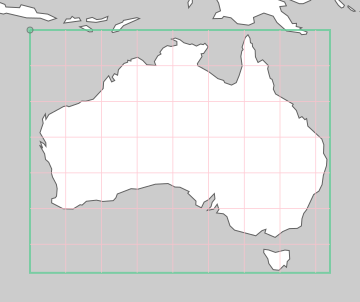

In [4]:
AusENDVI_clim_MCD43A4.odc.geobox

### Plot a smoothed timeseries

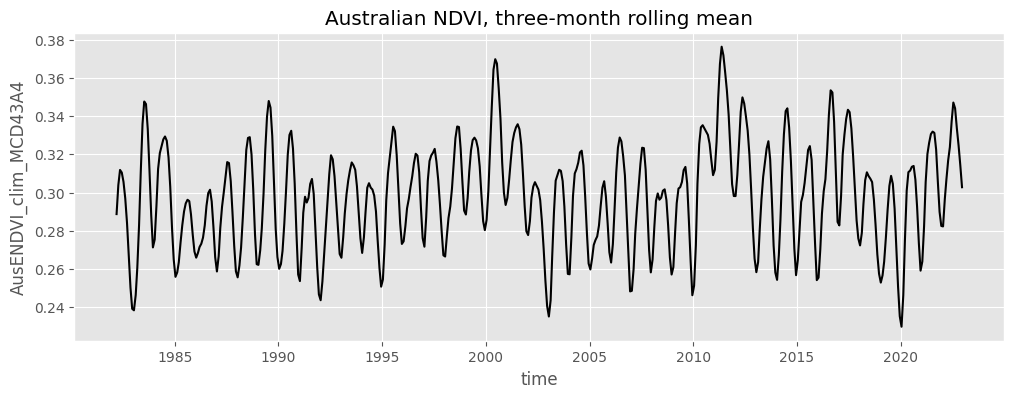

In [5]:
with plt.style.context('ggplot'):
    AusENDVI_clim_MCD43A4['AusENDVI_clim_MCD43A4'].mean(['latitude', 'longitude']).rolling(time=3).mean().plot(figsize=(12,4), c='black')
    plt.title('Australian NDVI, three-month rolling mean')

## Mask gap-filled pixels 

We can use the QC layer to mask pixels that were gapfilled.
The values in the QC layer are 0, 1, or 2:
- `0`: describes good observation data preserved from the original Climate Data Record AVHRR NDVI product after QA filtering and the extended filtering/removal of data that is described in the dataset's publication.
- `1`: Indicates data that is gap-filled using either synthetic NDVI data or values attained through linear temporal interpolation.
- `2`: Indicates pixels where there is no-data in the entire archive, effectively this is the land-sea mask

In [6]:
mask = AusENDVI_clim_MCD43A4['QC'] == 1
mask = ~mask #invert so good data is 1, gapfill is 0

#mask data
masked = AusENDVI_clim_MCD43A4['AusENDVI_clim_MCD43A4'].where(mask)

### Plot a time-step

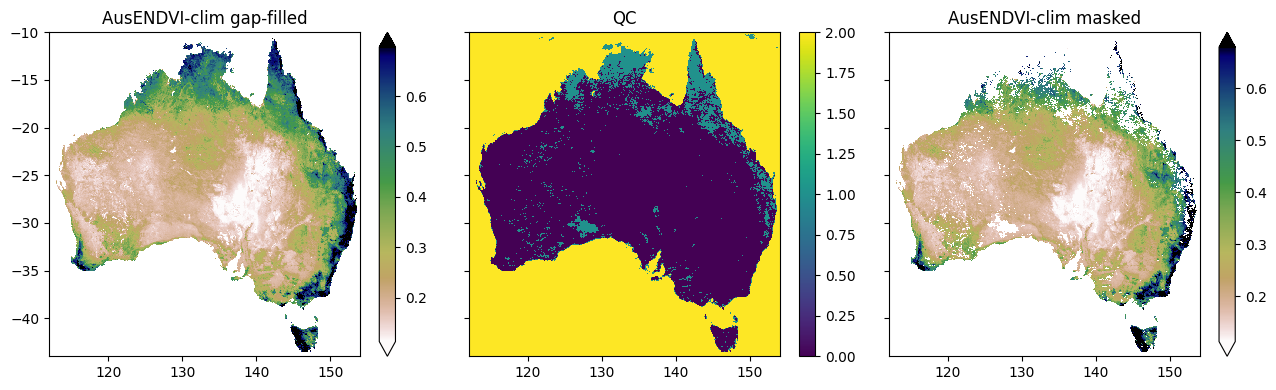

In [7]:
timestep=1

fig,ax = plt.subplots(1,3, figsize=(13,4), sharey=True)
AusENDVI_clim_MCD43A4['AusENDVI_clim_MCD43A4'].isel(time=timestep).plot(ax=ax[0], robust=True, cmap='gist_earth_r', add_labels=False)
AusENDVI_clim_MCD43A4['QC'].isel(time=timestep).plot(ax=ax[1], add_labels=False)
masked.isel(time=timestep).plot(ax=ax[2], robust=True, cmap='gist_earth_r', add_labels=False)
ax[0].set_title('AusENDVI-clim gap-filled')
ax[1].set_title('QC')
ax[2].set_title('AusENDVI-clim masked')
plt.tight_layout()

## Open `AusENDVI-synthetic`

This dataset consists of synthetic NDVI data that was built by training a gradient boosting model on the joined AusENDVI-clim and MODIS-MCD43A4 NDVI timeseries using climate, woody-cover-fraction, and atmospheric CO2 as predictors. The dataset extends from Jan. 1982 to Dec. 2022. This dataset was used to gapfill the AusENDVI-clim datasets.

In [8]:
AusENDVI_synthetic = xr.open_dataset(f'{path_to_data}AusENDVI_synthetic_1982_2022.nc')
AusENDVI_synthetic

<xarray.Dataset> Size: 1GB
Dimensions:             (longitude: 840, latitude: 680, time: 492)
Coordinates:
  * longitude           (longitude) float32 3kB 112.0 112.1 ... 153.9 154.0
  * latitude            (latitude) float32 3kB -10.02 -10.07 ... -43.92 -43.97
  * time                (time) datetime64[ns] 4kB 1982-01-15 ... 2022-12-15
Data variables:
    spatial_ref         int32 4B ...
    AusENDVI_synthetic  (time, latitude, longitude) float32 1GB ...
Attributes:
    nodata:       nan
    crs:          EPSG:4326
    description:  This dataset consists of synthetic NDVI data that was built...
    units:        unitless
    long_name:    AusENDVI Synthetic NDVI

### Plot synthetic data alongside AusENDVI-clim

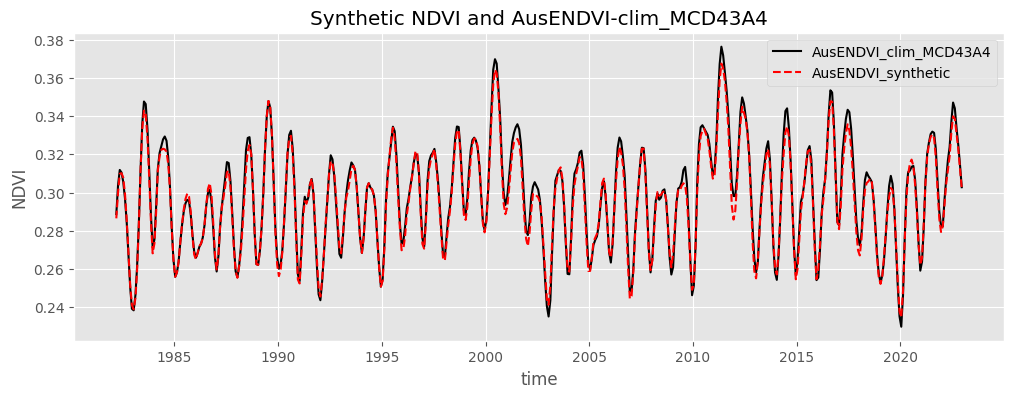

In [9]:
with plt.style.context('ggplot'):
    fig,ax = plt.subplots(1,1, figsize=(12,4), sharey=True)
    AusENDVI_clim_MCD43A4['AusENDVI_clim_MCD43A4'].mean(['latitude', 'longitude']).rolling(time=3).mean().plot(ax=ax, label='AusENDVI_clim_MCD43A4', c='black')
    AusENDVI_synthetic['AusENDVI_synthetic'].mean(['latitude', 'longitude']).rolling(time=3).mean().plot(ax=ax, label='AusENDVI_synthetic', c='red', linestyle='--')
    ax.set_ylabel('NDVI')
    ax.legend()
    plt.title('Synthetic NDVI and AusENDVI-clim_MCD43A4')

## Reproject data to coarser resolution

A potential use case for AusENDVI (especially the gap-filled 'clim' version) is to drive or validate a land surface model. Often, LSMs will have a coarser resolution than the 5 km resolution of AusENDVI.  Below, we show how to reproject a dataset to a coarser resolution using `odc-geo`. Ideally, we would reproject to the exact grid of another dataset, but in lieu of that we will create an example coarse resolution grid by 'zooming out' the AusENDVI grid.

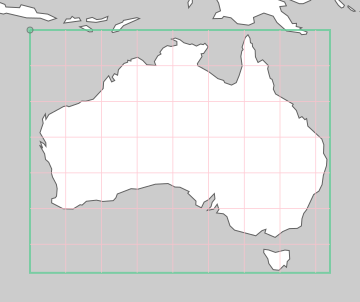

In [10]:
# Create a coarser scale grid using the AusENDVI grid
new_grid = AusENDVI_clim_MCD43A4.odc.geobox.zoom_out(factor=5)
new_grid

### Reproject

In [11]:
ndvi_clim_coarse = AusENDVI_clim_MCD43A4['AusENDVI_clim_MCD43A4'].odc.reproject(how=new_grid, resampling='average')

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/odc/geo/_xr_interop.py:435: UserWarning: grid_mapping=spatial_ref is not pointing to valid coordinate
  warnings.warn(


### Plot a time-step

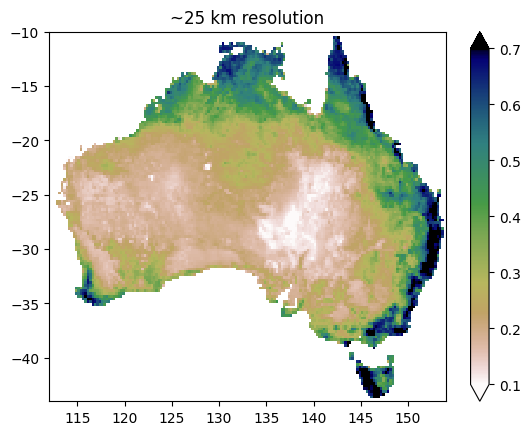

In [12]:
ndvi_clim_coarse.isel(time=timestep).plot.imshow(vmax=0.7, vmin=0.1, cmap='gist_earth_r', add_labels=False)
plt.title('~25 km resolution');

## Gap-fill a dataset using synthetic NDVI

We can fill gap-fill a dataset using the precise method used in the publication. First, we can fill short gaps using linear temporal interpolation, then larger gaps are filled with the synthetic data. We will gap-fill the `AusENDVI-clim_1982_2013` dataset.

In [13]:
# import data
AusENDVI_clim = xr.open_dataset(f'{path_to_data}AusENDVI-clim_1982_2013.nc')

### Fill short gaps with linear interpolation

In [14]:
# seperate into climatologies and anomalies
climatology = AusENDVI_clim.groupby('time.month').mean()
anomaly = AusENDVI_clim.groupby('time.month') - climatology  

# fill anomalies linearly by one-step
anomaly = anomaly.interpolate_na(dim='time', method='linear', limit=1)

# recombine anomalies and climatology
fill = anomaly.groupby('time.month') + climatology
fill = fill.drop_vars('month')

### Fill remaining data-gaps with synthetic data

In [15]:
AusENDVI_clim_gapfill = fill.fillna(AusENDVI_synthetic['AusENDVI_synthetic'])

### Plot gapfilled and original data

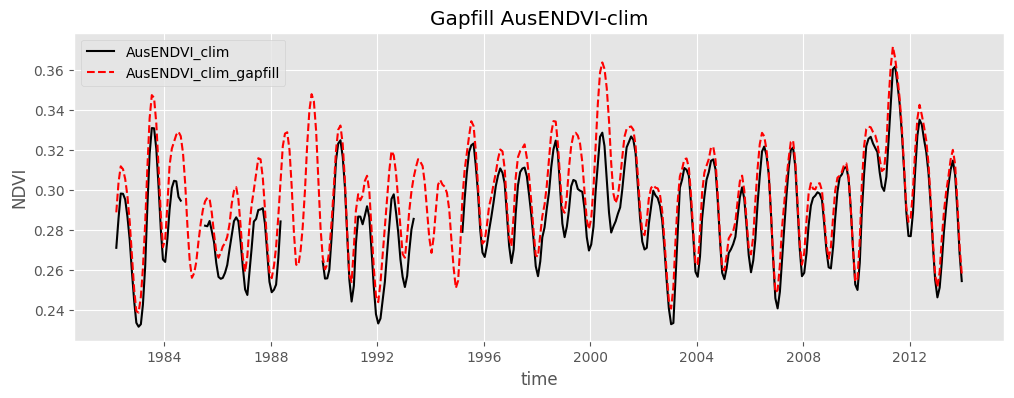

In [16]:
with plt.style.context('ggplot'):
    fig,ax = plt.subplots(1,1, figsize=(12,4), sharey=True)
    AusENDVI_clim['AusENDVI_clim'].mean(['latitude', 'longitude']).rolling(time=3).mean().plot(ax=ax, label='AusENDVI_clim', c='black')
    AusENDVI_clim_gapfill['AusENDVI_clim'].mean(['latitude', 'longitude']).rolling(time=3).mean().plot(ax=ax, label='AusENDVI_clim_gapfill', c='red', linestyle='--')
    ax.set_ylabel('NDVI')
    ax.legend()
    plt.title('Gapfill AusENDVI-clim');